# Comparison of Neural network, LSTM and HNN based integrator

In [ ]:
import sys
sys.path.append('..')

import numpy as np
from matplotlib import pyplot as plt
from Code.dynamical_system import *
from Code.time_integrator import *
from Code.neuralnet import *

np.random.seed(2512517)

## Neural network integrators

Set system parameters, construct dynamical system and integrators.

The model system we are using here is the harmonic oscillator.

The timestep size of all of the Neural network integrators is set to $40\Delta t_{\text{Verlet}}$ where $\Delta t_{\text{Verlet}}$ is the step size of the Verlet integrator that is used for training.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 2)]       0           []                               
                                                                                                  
 flatten (Flatten)              (None, 8)            0           ['input_1[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 64)           576         ['flatten[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 64)           4160        ['dense_4[0][0]']                
                                                                                              

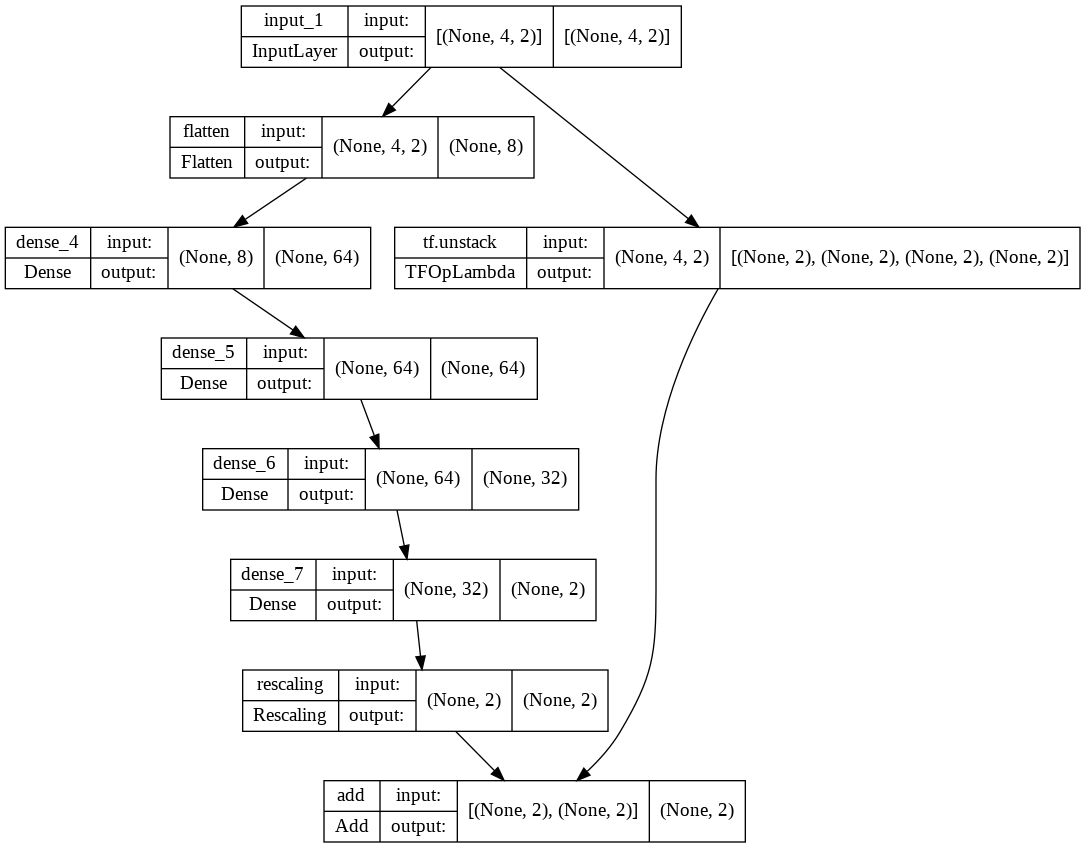

In [ ]:
# mass of particle
mass = 1.2
# spring constant of harmonic oscillator
k_spring = 0.9
# timestep for Verlet integrator
dt_verlet = 0.005
# timestep for neural network integrators
dt = 40*dt_verlet

# number of steps for neural network integrator
nsteps_1 = 4
#number of steps for the LSTM integrator
nsteps_2 = 5

harmonic_oscillator = FastHarmonicOscillator(mass,k_spring)

verlet_SHO = FastVerletIntegrator(harmonic_oscillator,dt_verlet)


# Layers for the potential and kinetic parts of the hamiltonian neural network integrator

V_pot_layers = [keras.layers.Dense(32,activation='tanh'),
                    keras.layers.Dense(32,activation='tanh')]
T_kin_layers = [keras.layers.Dense(32,activation='tanh'),
                    keras.layers.Dense(32,activation='tanh')]


nn_integrator_1 = NN5LR3Integrator(harmonic_oscillator,nsteps_1,dt)
nn_integrator_2 = LSTMFinalIntegrator(harmonic_oscillator,nsteps_2,dt)
nn_integrator_3 = HamiltonianNNIntegrator(harmonic_oscillator,dt,V_pot_layers,T_kin_layers)
verlet_dt = FastVerletIntegrator(harmonic_oscillator,dt)

# visualise the neural network model
nn_integrator_1.model.summary()
keras.utils.plot_model(nn_integrator_1.model, show_shapes=True)

In [ ]:
BATCH_SIZE=128

data_generator_1 = DataGenerator(nn_integrator_1,verlet_SHO)
train_batches_1 = data_generator_1.dataset.batch(BATCH_SIZE)

data_generator_2 = DataGenerator(nn_integrator_2,verlet_SHO)
train_batches_2 = data_generator_2.dataset.batch(BATCH_SIZE)

data_generator_3 = DataGenerator(nn_integrator_3,verlet_SHO)
train_batches_3 = data_generator_3.dataset.batch(BATCH_SIZE)


## Train neural network based integrator

In [ ]:
EPOCHS=1000
STEPS_PER_EPOCH=100
log_dir = './tb_logs/'
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

result_1 = nn_integrator_1.model.fit(train_batches_1,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)
result_2 = nn_integrator_2.model.fit(train_batches_2,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)
result_3 = nn_integrator_3.model.fit(train_batches_3,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                callbacks=tensorboard_cb)


Streaming output truncated to the last 5000 lines.
100/100 [==============================] - 4s 39ms/step - loss: 1.2311e-08
Epoch 502/1000
100/100 [==============================] - 4s 39ms/step - loss: 1.0410e-08
Epoch 503/1000
100/100 [==============================] - 4s 39ms/step - loss: 1.3803e-09
Epoch 504/1000
100/100 [==============================] - 4s 39ms/step - loss: 1.1908e-09
Epoch 505/1000
100/100 [==============================] - 4s 39ms/step - loss: 2.2751e-09
Epoch 506/1000
100/100 [==============================] - 4s 39ms/step - loss: 3.8389e-09
Epoch 507/1000
100/100 [==============================] - 4s 39ms/step - loss: 4.2031e-09
Epoch 508/1000
100/100 [==============================] - 4s 41ms/step - loss: 1.8181e-09
Epoch 509/1000
100/100 [==============================] - 4s 39ms/step - loss: 2.7150e-09
Epoch 510/1000
100/100 [==============================] - 4s 39ms/step - loss: 5.0213e-08
Epoch 511/1000
100/100 [==============================] - 4s 39m

## Visualise Loss function

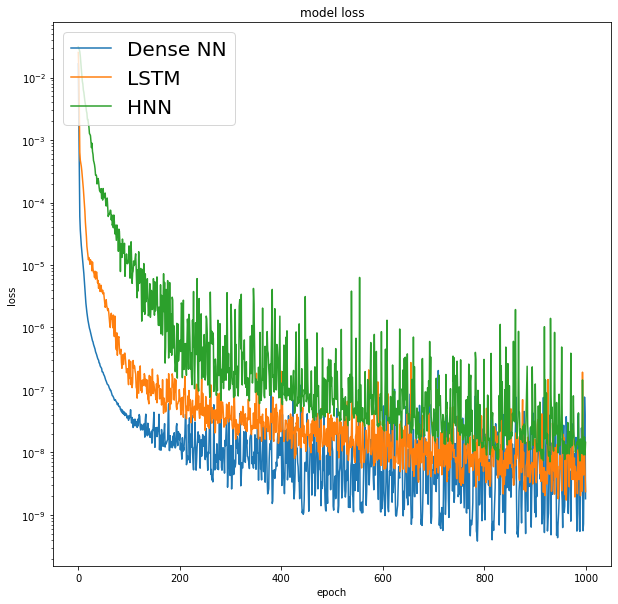

In [ ]:
#print(result.history.keys())

plt.rcParams['figure.figsize'] = [10, 10]

# summarize history for loss
plt.plot(result_1.history['loss'])
plt.plot(result_2.history['loss'])
plt.plot(result_3.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.legend(['Dense NN','LSTM','HNN'], loc='upper left')
plt.yscale("log")
plt.show()

## Plot trajectories generated to $t=512$ by Verlet integrator and neural networks


In [ ]:
# Final time
T_final = 512

# Initial conditions
x = np.zeros(1)
v = np.zeros(1)
x[0] = 2.70
v[0] = -0.6
verlet_SHO.set_state(x,v)

# ==== Verlet integrator ====
t = 0.0
t_verlet_SHO = []
x_verlet_SHO = []
v_verlet_SHO = []
E_verlet_SHO = []



while t<T_final:
    t_verlet_SHO.append(t)
    E_verlet_SHO.append(verlet_SHO.energy())
    x_verlet_SHO.append(verlet_SHO.x[0])
    v_verlet_SHO.append(verlet_SHO.v[0])
    verlet_SHO.integrate(1)
    t += dt_verlet



# ==== Verlet integrator 40dt_V====
t = 0.0
t_verlet_dt = []
x_verlet_dt = []
v_verlet_dt = []
E_verlet_dt = []


verlet_dt.set_state(x,v)
while t<T_final:
    t_verlet_dt.append(t)
    E_verlet_dt.append(verlet_dt.energy())
    x_verlet_dt.append(verlet_dt.x[0])
    v_verlet_dt.append(verlet_dt.v[0])
    verlet_dt.integrate(1)
    t += dt

        

# ==== Neural network integrators ====

# Initialise with Verlet integrator
x_initial_1 = np.zeros((nn_integrator_1.nsteps,nn_integrator_1.dynamical_system.dim))
v_initial_1 = np.zeros((nn_integrator_1.nsteps,nn_integrator_1.dynamical_system.dim))
x_initial_2 = np.zeros((nn_integrator_2.nsteps,nn_integrator_2.dynamical_system.dim))
v_initial_2 = np.zeros((nn_integrator_2.nsteps,nn_integrator_2.dynamical_system.dim))
x_initial_3 = np.zeros((nn_integrator_3.nsteps,nn_integrator_3.dynamical_system.dim))
v_initial_3 = np.zeros((nn_integrator_3.nsteps,nn_integrator_3.dynamical_system.dim))



verlet_SHO.set_state(x,v)
for k in range(nn_integrator_1.nsteps):    
    x_initial_1[k,:] = verlet_SHO.x[:]
    v_initial_1[k,:] = verlet_SHO.v[:]
    verlet_SHO.integrate(int(dt/dt_verlet))
verlet_SHO.set_state(x,v)
for k in range(nn_integrator_2.nsteps):    
    x_initial_2[k,:] = verlet_SHO.x[:]
    v_initial_2[k,:] = verlet_SHO.v[:]
    verlet_SHO.integrate(int(dt/dt_verlet))
verlet_SHO.set_state(x,v)
for k in range(nn_integrator_3.nsteps):    
    x_initial_3[k,:] = verlet_SHO.x[:]
    v_initial_3[k,:] = verlet_SHO.v[:]
    verlet_SHO.integrate(int(dt/dt_verlet))



nn_integrator_1.set_state(x_initial_1,v_initial_1)
t_1 = (nn_integrator_1.nsteps-1)*nn_integrator_1.dt
nn_integrator_2.set_state(x_initial_2,v_initial_2)
t_2 = (nn_integrator_2.nsteps-1)*nn_integrator_2.dt
nn_integrator_3.set_state(x_initial_3,v_initial_3)
t_3 = (nn_integrator_3.nsteps-1)*nn_integrator_3.dt




# Timestepping loop
t_nn_1 = []
x_nn_1 = []
v_nn_1 = []
E_nn_1 = []
t_nn_2 = []
x_nn_2 = []
v_nn_2 = []
E_nn_2 = []
t_nn_3 = []
x_nn_3 = []
v_nn_3 = []
E_nn_3 = []



while t_1<T_final:
    t_nn_1.append(t_1)
    x_nn_1.append(nn_integrator_1.x[0])
    v_nn_1.append(nn_integrator_1.v[0])
    E_nn_1.append(nn_integrator_1.energy())
    nn_integrator_1.integrate(1)
    t_1 += dt
while t_2<T_final:
    t_nn_2.append(t_2)
    x_nn_2.append(nn_integrator_2.x[0])
    v_nn_2.append(nn_integrator_2.v[0])
    E_nn_2.append(nn_integrator_2.energy())
    nn_integrator_2.integrate(1)
    t_2 += dt
while t_3<T_final:
    t_nn_3.append(t_3)
    x_nn_3.append(nn_integrator_3.x[0])
    v_nn_3.append(nn_integrator_3.v[0])
    E_nn_3.append(nn_integrator_3.energy())
    nn_integrator_3.integrate(1)
    t_3 += dt

 



x_nn_1 = np.array(x_nn_1)
x_nn_2 = np.array(x_nn_2)
x_nn_3 = np.array(x_nn_3)
x_verlet_SHO = np.array(x_verlet_SHO)
x_verlet_dt = np.array(x_verlet_dt)
v_nn_1 = np.array(v_nn_1)
v_nn_2 = np.array(v_nn_2)
v_nn_3 = np.array(v_nn_3)
v_verlet_SHO = np.array(v_verlet_SHO)
v_verlet_dt = np.array(v_verlet_dt)



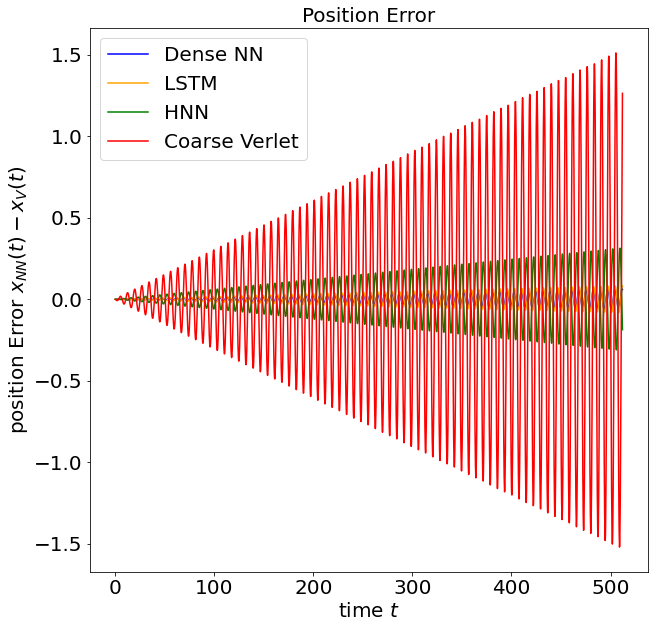

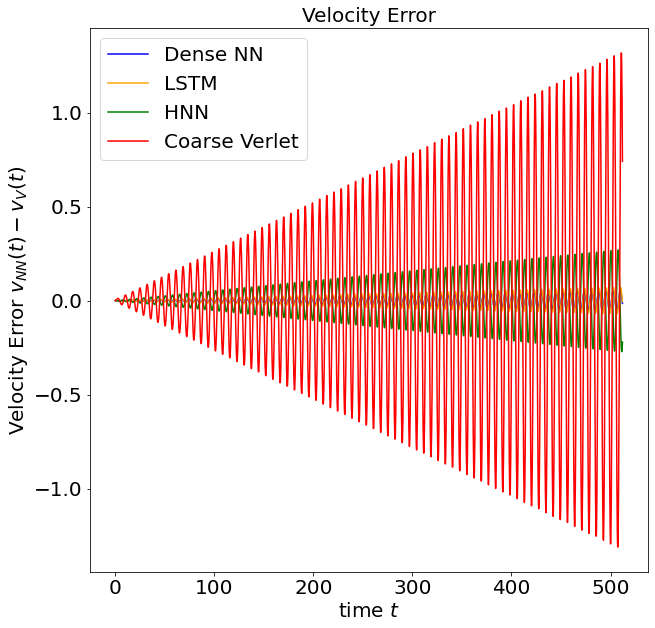

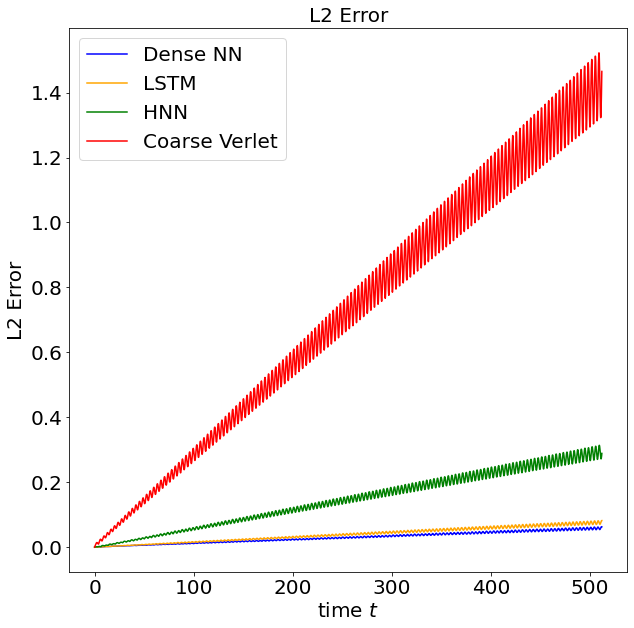

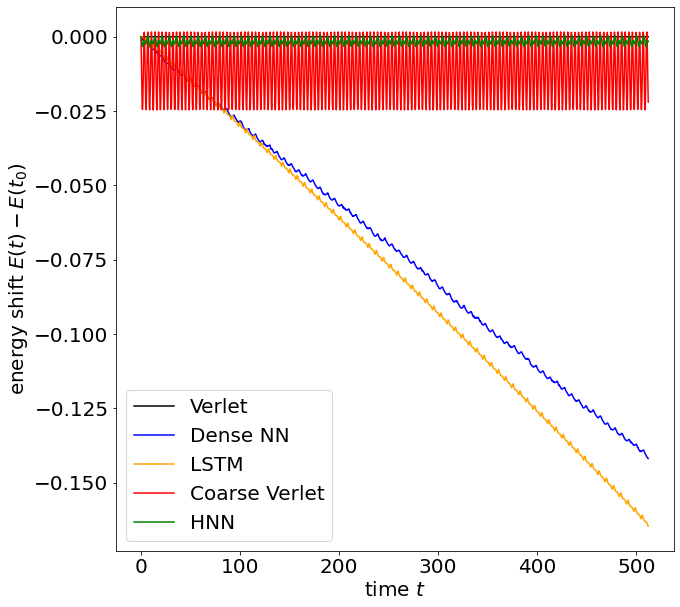

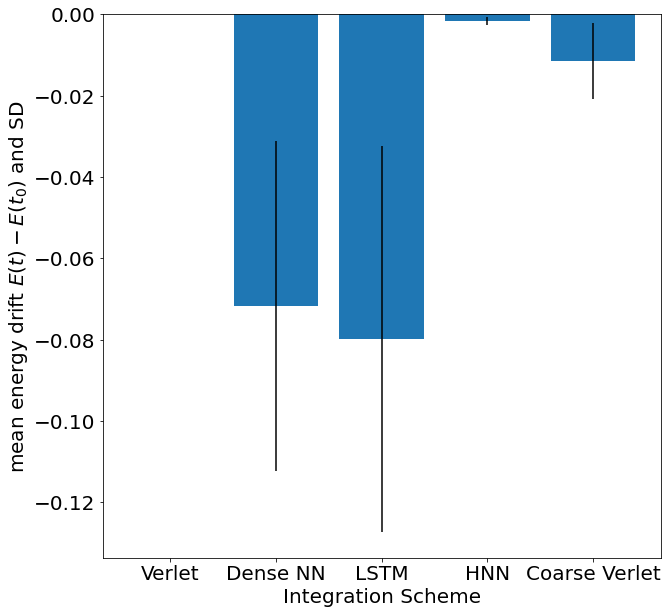

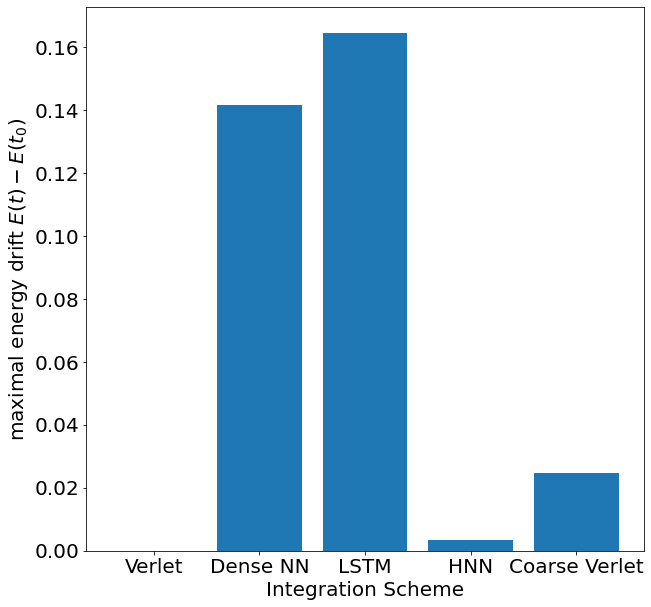

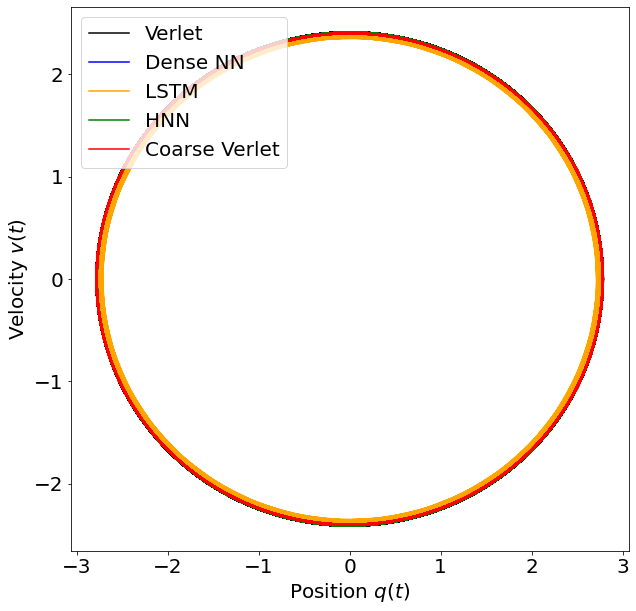

In [ ]:
# Plot position error as a function of time
plt.clf()
plt.rcParams['figure.figsize'] = [10, 10]

plt.plot(t_nn_1,x_nn_1-x_verlet_SHO[int((nsteps_1-1)*dt/dt_verlet)::int(dt/dt_verlet)],label='Dense NN',color='blue')
plt.plot(t_nn_2,x_nn_2-x_verlet_SHO[int((nsteps_2-1)*dt/dt_verlet)::int(dt/dt_verlet)],label='LSTM',color='orange')
plt.plot(t_nn_3,x_nn_3-x_verlet_SHO[::int(dt/dt_verlet)],label='HNN',color='green')
plt.plot(t_verlet_dt,x_verlet_dt-x_verlet_SHO[::int(dt/dt_verlet)],label='Coarse Verlet',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('position Error $x_{NN}(t)-x_V(t)$')
ax.set_title('Position Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

# Plot velocity error as a function of time

plt.plot(t_nn_1,v_nn_1-v_verlet_SHO[int((nsteps_1-1)*dt/dt_verlet)::int(dt/dt_verlet)],label='Dense NN',color='blue')
plt.plot(t_nn_2,v_nn_2-v_verlet_SHO[int((nsteps_2-1)*dt/dt_verlet)::int(dt/dt_verlet)],label='LSTM',color='orange')
plt.plot(t_nn_3,v_nn_3-v_verlet_SHO[::int(dt/dt_verlet)],label='HNN',color='green')
plt.plot(t_verlet_dt,v_verlet_dt-v_verlet_SHO[::int(dt/dt_verlet)],label='Coarse Verlet',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('Velocity Error $v_{NN}(t)-v_V(t)$')
ax.set_title('Velocity Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

# Plot L2 error as a function of time

plt.plot(t_nn_1,((v_nn_1-v_verlet_SHO[int((nsteps_1-1)*dt/dt_verlet)::int(dt/dt_verlet)])**2+(x_nn_1-x_verlet_SHO[int((nsteps_1-1)*dt/dt_verlet)::int(dt/dt_verlet)])**2)**0.5,label='Dense NN',color='blue')
plt.plot(t_nn_2,((v_nn_2-v_verlet_SHO[int((nsteps_2-1)*dt/dt_verlet)::int(dt/dt_verlet)])**2+(x_nn_2-x_verlet_SHO[int((nsteps_2-1)*dt/dt_verlet)::int(dt/dt_verlet)])**2)**0.5,label='LSTM',color='orange')
plt.plot(t_nn_3,((v_nn_3-v_verlet_SHO[::int(dt/dt_verlet)])**2+(x_nn_3-x_verlet_SHO[::int(dt/dt_verlet)])**2)**0.5,label='HNN',color='green')
plt.plot(t_verlet_dt,((v_verlet_dt-v_verlet_SHO[::int(dt/dt_verlet)])**2+(x_verlet_dt-x_verlet_SHO[::int(dt/dt_verlet)])**2)**0.5,label='Coarse Verlet',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('L2 Error')
ax.set_title('L2 Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()


plt.clf()
# Plot energy as a function of time
# (subtract energy at time t=0 to show energy drift)

plt.plot(t_verlet_SHO,E_verlet_SHO-E_verlet_SHO[0],label='Verlet',color='black')
plt.plot(t_nn_1,E_nn_1-E_nn_1[0],label='Dense NN',color='blue')
plt.plot(t_nn_2,E_nn_2-E_nn_2[0],label='LSTM',color='orange')
plt.plot(t_verlet_dt,E_verlet_dt-E_verlet_dt[0],label='Coarse Verlet',color='red')
plt.plot(t_nn_3,E_nn_3-E_nn_3[0],label='HNN',color='green')
plt.legend(loc='lower left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('energy shift $E(t)-E(t_0)$')
#ax.grid()
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

plt.show()


# Plot average energy drift and standard deviation for each integrator.

tags = np.array(['Verlet','Dense NN','LSTM','HNN','Coarse Verlet'])
maxima = np.array([np.amax(np.abs(E_verlet_SHO-E_verlet_SHO[0])),np.amax(np.abs(E_nn_1-E_nn_1[0])),np.amax(np.abs(E_nn_2-E_nn_2[0])),np.amax(np.abs(E_nn_3-E_nn_3[0])),np.amax(np.abs(E_verlet_dt-E_verlet_dt[0]))])
means = np.array([np.mean(E_verlet_SHO-E_verlet_SHO[0]),np.mean(E_nn_1-E_nn_1[0]),np.mean(E_nn_2-E_nn_2[0]),np.mean(E_nn_3-E_nn_3[0]),np.mean(E_verlet_dt-E_verlet_dt[0])])
std = np.array([np.std(E_verlet_SHO-E_verlet_SHO[0]),np.std(E_nn_1-E_nn_1[0]),np.std(E_nn_2-E_nn_2[0]),np.std(E_nn_3-E_nn_3[0]),np.std(E_verlet_dt-E_verlet_dt[0])])
tagsticks = np.array([0,1,2,3,4])

#plt.bar(tags,maxima)
plt.bar(tags,means,yerr=std)
ax = plt.gca()
ax.set_xlabel('Integration Scheme')
ax.set_ylabel('mean energy drift $E(t)-E(t_0)$ and SD')
plt.xticks(tagsticks,tags)

#ax.grid()
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

plt.show()

plt.clf()
plt.bar(tags,maxima)
ax = plt.gca()
ax.set_xlabel('Integration Scheme')
ax.set_ylabel('maximal energy drift $E(t)-E(t_0)$')
plt.xticks(tagsticks,tags)
plt.show()
#subplots of position versus velocity for all 4

plt.rcParams['figure.figsize'] = [10, 10]

plt.clf()
plt.plot(x_verlet_SHO,v_verlet_SHO,label='Verlet',color='black')
plt.plot(x_nn_1,v_nn_1,label='Dense NN',color='blue')
plt.plot(x_nn_2,v_nn_2,label='LSTM',color='orange')
plt.plot(x_nn_3,v_nn_3,label='HNN',color='green')
plt.plot(x_verlet_dt,v_verlet_dt,label='Coarse Verlet',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylabel('Velocity $v(t)$')
ax.set_xlabel('Position $q(t)$')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.show()